In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
fx_rates = pd.read_excel("./Data/FX_ALL_MONTHLY.xlsx", index_col=0)
fx_rates = fx_rates[fx_rates!=0].dropna()
fx_rates.index = pd.to_datetime(fx_rates.index)
fx_rates = fx_rates.sort_index()
equities = pd.read_excel("./Data/MSCI_ALL_LOCAL_MONTHLY.xlsx", index_col=0, sheet_name="Sheet1")
equities = equities.sort_index()
interestrates = pd.read_excel("./Data/3M_INTEREST_RATES_MONTHLY.xlsx", index_col=0).dropna()
interestrates.columns=pd.read_excel("./Data/3M_interest_rates.xlsx").columns
interestrates.index = pd.to_datetime(interestrates.index)
interestrates = interestrates.sort_index()

In [3]:
def excess_equity_returns(equity_returns, stfir):
    #stfir: short-term foreign interest rate
    
    # ensure index is sorted
    equity_returns = equity_returns.sort_index()
    stfir = stfir.sort_index()
    
    #ensure index matches
    equity_returns = equity_returns[equity_returns.index.isin(stfir.index)]
    stfir = stfir[stfir.index.isin(equity_returns.index)]
    
    return equity_returns - stfir

def excess_currency_returns(r_fx, fi, di):
    # r_fx: exchange rate returns, fi: foreign interest rate, di: domestic interest rate
    # calculate returns by using a 3 month shift
    r_fx = (r_fx.iloc[3:,:].values/r_fx.iloc[:-3,:] -1) * 100
    # exclude domestic currency name from fx rate names
    r_fx.columns = [name.replace(di.name, "") for name in r_fx.columns]
    # sort the columns as in the interest rates df
    r_fx = r_fx[fi.columns]
    
    return r_fx + (fi.sub(di, axis="rows"))

def sigma_fx(r_fx, fi, di):
    # get excess returns
    excess_r = excess_currency_returns(r_fx, fi, di)
    # return their variance-covariance matirx / pandas cov()
    return excess_r.cov()

def sigma_eqfx(r_eq, r_fx):
    pass

def fx_hedge_weights():
    pass

def alpha_hedge_weights(alpha_eq, alpha_fx):
    # alpha_eq: expected excess returns for hedged equities, alpha_fx:  currency expected excess returns
    sigma_fx_inv = np.linalg.pinv(sigma_fx(r_fx, fi, di))
    w_hedge = sigma_fx_inv.dot()
    k = 0
    w_opt = sigma_fx_inv * (-w_hedge + k * w_alpha)
    pass

In [4]:
domestic_currency="CHF"
# Calculate Excess Equity returns
# Calculate returns for 3 month holing period in local currencies
eq_returns = equities.rolling(3).agg(lambda x: (x[-1]/x[0]-1)*100)
# Calculate excess returns
alpha_eq = pd.DataFrame(columns=interestrates.columns, index = interestrates.index)
alpha_eq["CHF"] = excess_equity_returns(eq_returns["MXUS Index"], interestrates["CHF"])
alpha_eq["USD"] = excess_equity_returns(eq_returns["MSDLE15 Index"], interestrates["USD"][:-3])
alpha_eq["EUR"] = excess_equity_returns(eq_returns["MSDLUK Index"], interestrates["EUR"][:-3])
alpha_eq["CAD"] = excess_equity_returns(eq_returns["MSDLCA Index"], interestrates["CAD"][:-3])
alpha_eq["GBP"] = excess_equity_returns(eq_returns["MSDLE15 Index"], interestrates["GBP"][:-3])
alpha_eq["JPY"] = excess_equity_returns(eq_returns["MSDLJN Index"], interestrates["JPY"][:-3])
alpha_eq["AUD"] = excess_equity_returns(eq_returns["MSDLAS Index"], interestrates["AUD"][:-3])

CHF    0.658060
USD   -1.712240
EUR   -1.468197
GBP   -2.311632
JPY    0.094748
CAD   -1.434351
AUD   -3.359708
dtype: float64


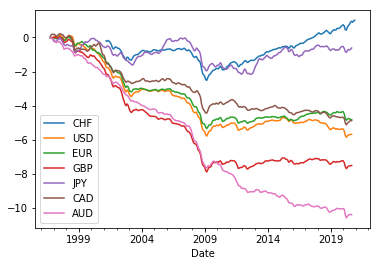

In [5]:
# Approximation of average excess returns (of local equity indices)---> this seems wrong there should be a risk premium
print(alpha_eq.mean())
# plotting the cumulative excess returns
np.log(alpha_eq/100+1).cumsum().plot()

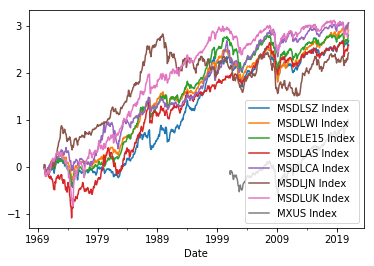

In [6]:
# Cumulative monthly log returns
np.log(1+(equities.pct_change())).cumsum().plot()

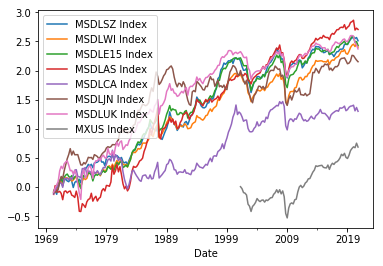

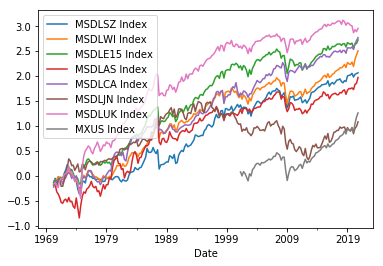

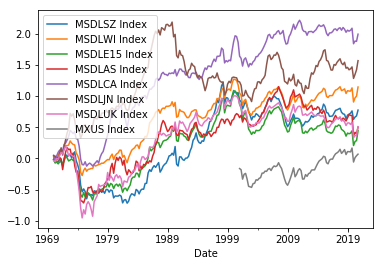

In [7]:
# eq_returns are 3 month returns
# 3 month returns every three months (cumulative log returns)
np.log(eq_returns.iloc[::3,:]/100 + 1).cumsum().plot()
# 3 month returns every three months with offset 1 (cumulative log returns)
np.log(eq_returns.iloc[1::3,:]/100 + 1).cumsum().plot()
# 3 month returns every three months with offset 2 (cumulative log returns)
np.log(eq_returns.iloc[2::3,:]/100 + 1).cumsum().plot()

In [8]:
# Calculate Excess Currency returns
interestrates = interestrates[interestrates.index.isin(fx_rates.index)]
fx_rates = fx_rates[fx_rates.index.isin(interestrates.index)]
fi = interestrates[[cur for cur in interestrates.columns if cur != domestic_currency ]]
di = interestrates[domestic_currency]
excess_currency_returns(fx_rates, fi, di)

,USD,EUR,GBP,JPY,CAD,AUD
Date,,,,,,
1999-01-31,-3.481409,1.086855,-0.303085,-5.421196,-6.698749,-7.200361
1999-02-28,-1.485637,1.572643,-1.019317,-4.389971,-3.792637,-2.638905
1999-03-31,-0.472430,1.038092,1.782919,-3.555683,-3.379617,-3.807497
1999-04-30,6.329516,2.654730,5.733952,-2.697058,9.589905,4.545597
1999-05-31,4.836692,1.073690,5.108488,-9.921166,5.911387,6.339225
1999-06-30,7.643199,1.699081,3.281711,-10.159670,7.446757,5.339304
1999-07-31,2.236463,1.862309,0.717028,-11.959417,-0.563370,2.611228
1999-08-31,-0.104915,2.337327,-0.057909,-12.764509,-1.915237,0.248988
1999-09-30,-1.827063,1.389291,-0.735689,-11.033090,-4.344624,-0.050470
